In [147]:
import pandas as pd
import numpy as np
import prework as pwk
import string
import sys, os, io


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.doc2vec import LabeledSentence, Doc2Vec, Word2Vec
from gensim.utils import simple_preprocess, simple_tokenize
from collections import Counter

In [64]:
sentences = [['first', 'sentence'], ['second', 'sentence']]
model1 = Word2Vec(sentences, min_count=1)
#print model1.similarity('third','sentence')

#let this be the model from which you want to reset
sentences = [['third', 'sentence'], ['fourth', 'sentence']]
model2 = Word2Vec(sentences, min_count=1)
model1.reset_from(model2)
print model1.similarity('third','sentence')

-0.0646220009883


In [2]:
import sys
stdout = sys.stdout

reload(sys)
sys.setdefaultencoding('utf-8')

sys.stdout = stdout

In [3]:
root = 'data/pilot'
#root = 'data/ICNALE/Unmerged_classified'

## Load Raw Data

In [4]:
df_orig = pwk.load_data(root, 1, 'CHN', 'ENS')
df_orig.head(1)

209


,doc_id,path,author_code,essay_content,label,target
0,1,data/pilot/W_CHN_PTJ0_021_A2_0.txt,W_CHN_PTJ0_021_A2_0.txt,﻿I agree that it is important for college stud...,CHN,1


In [5]:
df_orig.shape

(209, 6)

## Feature Engineering

In [6]:
df_1 = df_orig.drop('path', axis=1)

In [7]:
pd.set_option('display.max_colwidth', -1)

In [8]:
sum(df_1['label']=='CHN')*1./df_1.shape[0]

0.52153110047846885

In [20]:
#df_1[['essay_content','label']]
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import nltk

In [112]:
train_data, test_data = train_test_split(df_1, test_size=0.1)

In [143]:
train_tagged = train_data.apply(\
    #lambda r: TaggedDocument(words=tokenize_text(r['essay_content']), tags=[r.label]), axis=1)
    lambda r: TaggedDocument(words=simple_preprocess(r['essay_content']), tags=[r.label]), axis=1)

In [155]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=simple_preprocess(r['essay_content']), tags=[r.label]), axis=1)

In [157]:
test_tagged.values[9]

TaggedDocument(words=[u'many', u'parents', u'want', u'their', u'students', u'to', u'be', u'more', u'responsible', u'many', u'students', u'want', u'to', u'have', u'more', u'freedom', u'one', u'way', u'for', u'both', u'groups', u'to', u'have', u'winning', u'solution', u'is', u'for', u'the', u'college', u'students', u'to', u'have', u'part', u'time', u'job', u'so', u'think', u'it', u'is', u'good', u'thing', u'for', u'college', u'students', u'to', u'have', u'part', u'time', u'job', u'the', u'students', u'for', u'their', u'part', u'demonstrate', u'to', u'their', u'parents', u'that', u'they', u'are', u'responsible', u'and', u'ready', u'enough', u'to', u'have', u'part', u'time', u'job', u'and', u'to', u'function', u'effectively', u'in', u'the', u'business', u'world', u'the', u'parents', u'will', u'see', u'that', u'their', u'children', u'are', u'becoming', u'responsible', u'and', u'be', u'willing', u'to', u'give', u'them', u'more', u'leeway', u'to', u'do', u'as', u'they', u'please', u'they', u'

In [116]:
trainsent = train_tagged.values
testsent = test_tagged.values

#simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, size=5, iter=20, dm=1)

In [142]:
#simple_preprocess(train_tagged.values[6].words)

In [152]:
#train_tagged.values

In [63]:
doc2vec_model.infer_vector(train_tagged.values[5].words, steps=20)

array([ 0.39795774, -0.22801702, -2.42773151,  1.22191691, -0.74887758], dtype=float32)

In [69]:
doc2vec_model.infer_vector(train_tagged.values[7].words, steps=20)

array([ 0.31919047, -0.96560031, -2.26834393,  1.14743721, -0.8488428 ], dtype=float32)

In [43]:
#train_targets, train_regressors = zip(
    #*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

In [79]:
cv_data, test_data = train_test_split(df_1, test_size=0.1)
cv_train_data, cv_test_data = train_test_split(cv_data, test_size=0.5)

In [17]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [41]:
def tag_docs(docs, col):
    tagged = docs.apply(\
            lambda r: TaggedDocument(words=tokenize_text(r[col]), tags=[r.label]), axis=1)
    return tagged

In [47]:
def train_doc2vec_model_new(tagged_docs):    
    sents = tagged_docs.values
    # train doc2vec model to get vector representation of documents
    doc2vec_model = Doc2Vec(sents, size=5, iter=20, dm=1)
    return doc2vec_model

In [48]:
def vec_for_learning(doc2vec_model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(\
            *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [96]:
X = cv_data.reindex(range(cv_data.shape[0]))

In [111]:
#from sklearn.cro import KFold
kf = KFold(n=cv_data.shape[0], n_folds=5)
X = cv_data
for train, test in kf:
    cv_train_data = X.iloc[train]
    cv_test_data = X.iloc[test]
    
    train_docs = tag_docs(cv_train_data, 'essay_content')
    test_docs = tag_docs(cv_test_data, 'essay_content')
    model = train_doc2vec_model_new(train_docs)
    
    y_train, X_train = vec_for_learning(model, train_docs)
    y_test, X_test = vec_for_learning(model, test_docs)
    
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    print accuracy_score(y_test, y_pred)

1.0
1.0
1.0
1.0
0.945945945946


In [56]:
cv_train_data, cv_test_data = train_test_split(cv_data, test_size=0.5)

In [135]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

def tag_docs(docs, col):
    tagged = docs.apply(lambda r: TaggedDocument(words=r[col], tags=[r.label]), axis=1)
    return tagged

def train_doc2vec_model_new(tagged_docs, window, size):    
    sents = tagged_docs.values
    # train doc2vec model to get vector representation of documents
    doc2vec_model = Doc2Vec(sents, size=size, window=window, iter=20, dm=1)
    return doc2vec_model

def vec_for_learning(doc2vec_model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(\
            *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [136]:
train_docs = tag_docs(cv_train_data, 'essay_content')
test_docs = tag_docs(cv_test_data, 'essay_content')
model = train_doc2vec_model_new(train_docs, 5, 10)
y_train, X_train = vec_for_learning(model, train_docs)
y_test, X_test = vec_for_learning(model, test_docs)

In [58]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy_score(y_test, y_pred)

0.93617021276595747

### Unique words per essay

**Unique words**

In [10]:
df_1['unique_words'] = df_1['essay_content'].apply(lambda x: len(set([word.lower().strip(string.punctuation) \
                                                              for word in x.split(' ')])))

**Stemming**

In [11]:
stemmer = SnowballStemmer('english')
#df_1['unique_stemmer'] = df_1['essay_content'].apply(lambda x: len(set([stemmer.stem(word) for word in [word.lower().strip(string.punctuation) \
                                                              #for word in x.split(' ')]])))

**Lemmatizing**

In [12]:
lmtzr = WordNetLemmatizer()
lmtzr.lemmatize('having')
#stemmer.stem('having')

'having'

In [13]:
lmtzr = WordNetLemmatizer()
df_1['unique_lemma'] = df_1['essay_content'].apply(lambda x: len(set([lmtzr.lemmatize(word) for word in [word.lower().strip(string.punctuation) \
                                                              for word in x.split(' ')]])))

In [14]:
df_1.head(1)

,doc_id,author_code,essay_content,label,target,unique_words,unique_lemma
0,1,W_CHN_PTJ0_021_A2_0.txt,"﻿I agree that it is important for college students to have apart-time job. Nowadays, a large number of college students are having a part-time job. Some of them hold that part-time jobs can help them to adapt to the society well and give them many experiences. Take a friend of mine for example, when Lily was a college student, she went to supermarket as a promoter or went to be a family teacher every weekend. Then owing to her experiences, she quickly got a good job after graduating from university. in the other students' opinions, they think that they can buy goods they want their parents cannot afford. I know a student that he goes to a restaurant as a waiter at his part-time to earn enough money what a computer needs. Thus, it is important for college students to have a part-time job. However, our parents always don't agree us to get part-time jobs. They are afraid that our study and safety. In my opinion, having a good part-time job is good for students. We should pay attention to the advantages of part-time jobs and make the most of them. Meanwhile, we should learn to get knowledge from the part-time jobs and make them a helpful tool for our development.",CHN,1,115,110


## Test SpaCy

In [15]:
import spacy
spc_nlp = spacy.load('en')

In [16]:
word = spc_nlp(u'I have a saw.')

In [17]:
[token.lemma_ for token in word]

[u'-PRON-', u'have', u'a', u'saw', u'.']

In [18]:
doc = spc_nlp(u"I agree that it is important for college students to have apart-time job. Nowadays, a large number of college students are having a part-time job. Some of them hold that part-time jobs can help them to adapt to the society well and give them many experiences. Take a friend of mine for example, when Lily was a college student, she went to supermarket as a promoter or went to be a family teacher every weekend. Then owing to her experiences, she quickly got a good job after graduating from university. in the other students' opinions, they think that they can buy goods they want their parents cannot afford. I know a student that he goes to a restaurant as a waiter at his part-time to earn enough money what a computer needs. Thus, it is important for college students to have a part-time job. However, our parents always don't agree us to get part-time jobs. They are afraid that our study and safety. In my opinion, having a good part-time job is good for students. We should pay attention to the advantages of part-time jobs and make the most of them. Meanwhile, we should learn to get knowledge from the part-time jobs and make them a helpful tool for our development.")

In [19]:
doc

I agree that it is important for college students to have apart-time job. Nowadays, a large number of college students are having a part-time job. Some of them hold that part-time jobs can help them to adapt to the society well and give them many experiences. Take a friend of mine for example, when Lily was a college student, she went to supermarket as a promoter or went to be a family teacher every weekend. Then owing to her experiences, she quickly got a good job after graduating from university. in the other students' opinions, they think that they can buy goods they want their parents cannot afford. I know a student that he goes to a restaurant as a waiter at his part-time to earn enough money what a computer needs. Thus, it is important for college students to have a part-time job. However, our parents always don't agree us to get part-time jobs. They are afraid that our study and safety. In my opinion, having a good part-time job is good for students. We should pay attention to t

In [20]:
e_spacy = set([token.lemma_ for token in doc if token.is_punct==False])

In [21]:
e_nltk = set([lmtzr.lemmatize(word) for word in [word.lower().strip(string.punctuation) for word in doc.text.split(' ')]])

In [22]:
len(e_spacy)

93

In [23]:
len(e_nltk)

109

## Compare spaCy and NLTK

In [24]:
dif =  e_spacy^e_nltk

In [25]:
#dif

In [26]:
#e_spacy

**lemmatizing**

In [27]:
df_1['spacy_lemma'] = df_1['essay_content'].apply(lambda x: len(set([token.lemma_ for token in spc_nlp(x.decode('utf-8')) if token.is_punct==False])))

**spaCy doesn not have stemming because they believe that stemming doesn't provide good info**

In [28]:
df_1.head(1)

,doc_id,author_code,essay_content,label,target,unique_words,unique_lemma,spacy_lemma
0,1,W_CHN_PTJ0_021_A2_0.txt,"﻿I agree that it is important for college students to have apart-time job. Nowadays, a large number of college students are having a part-time job. Some of them hold that part-time jobs can help them to adapt to the society well and give them many experiences. Take a friend of mine for example, when Lily was a college student, she went to supermarket as a promoter or went to be a family teacher every weekend. Then owing to her experiences, she quickly got a good job after graduating from university. in the other students' opinions, they think that they can buy goods they want their parents cannot afford. I know a student that he goes to a restaurant as a waiter at his part-time to earn enough money what a computer needs. Thus, it is important for college students to have a part-time job. However, our parents always don't agree us to get part-time jobs. They are afraid that our study and safety. In my opinion, having a good part-time job is good for students. We should pay attention to the advantages of part-time jobs and make the most of them. Meanwhile, we should learn to get knowledge from the part-time jobs and make them a helpful tool for our development.",CHN,1,115,110,94


## Average Sentence Length

In [29]:
doc = spc_nlp(u"I agree that it is important for college students to have apart-time job. Nowadays, a large number of college students are having a part-time job. Some of them hold that part-time jobs can help them to adapt to the society well and give them many experiences. Take a friend of mine for example, when Lily was a college student, she went to supermarket as a promoter or went to be a family teacher every weekend. Then owing to her experiences, she quickly got a good job after graduating from university. in the other students' opinions, they think that they can buy goods they want their parents cannot afford. I know a student that he goes to a restaurant as a waiter at his part-time to earn enough money what a computer needs. Thus, it is important for college students to have a part-time job. However, our parents always don't agree us to get part-time jobs. They are afraid that our study and safety. In my opinion, having a good part-time job is good for students. We should pay attention to the advantages of part-time jobs and make the most of them. Meanwhile, we should learn to get knowledge from the part-time jobs and make them a helpful tool for our development.")

In [30]:
sentences = doc.sents

In [31]:
ss = len([s for s in sentences])

In [32]:
ss

13

In [33]:
avg_slen = np.mean(ss)

In [34]:
avg_slen

13.0

In [35]:
df_1['avg_stc_length'] = df_1['essay_content'].apply(lambda x: np.mean([len(s.string.strip().split(' ')) for s in spc_nlp(x.decode('utf-8')).sents]))

In [36]:
df_1.head(1)

,doc_id,author_code,essay_content,label,target,unique_words,unique_lemma,spacy_lemma,avg_stc_length
0,1,W_CHN_PTJ0_021_A2_0.txt,"﻿I agree that it is important for college students to have apart-time job. Nowadays, a large number of college students are having a part-time job. Some of them hold that part-time jobs can help them to adapt to the society well and give them many experiences. Take a friend of mine for example, when Lily was a college student, she went to supermarket as a promoter or went to be a family teacher every weekend. Then owing to her experiences, she quickly got a good job after graduating from university. in the other students' opinions, they think that they can buy goods they want their parents cannot afford. I know a student that he goes to a restaurant as a waiter at his part-time to earn enough money what a computer needs. Thus, it is important for college students to have a part-time job. However, our parents always don't agree us to get part-time jobs. They are afraid that our study and safety. In my opinion, having a good part-time job is good for students. We should pay attention to the advantages of part-time jobs and make the most of them. Meanwhile, we should learn to get knowledge from the part-time jobs and make them a helpful tool for our development.",CHN,1,115,110,94,16.230769


## Synonyms count in each Doc

In [37]:
from nltk.corpus import wordnet as wn
def syn(word, lch_threshold=2.26):
    for net1 in wn.synsets(word):
        for net2 in wn.all_synsets():
            try:
                lch = net1.lch_similarity(net2)
            except:
                continue
            # The value to compare the LCH to was found empirically.
            # (The value is very application dependent. Experiment!)
            if lch >= lch_threshold:
                yield (net1, net2, lch)

### Total sentence count

In [38]:
df_1['toatl_sents'] = df_1['essay_content'].apply(lambda x: len([s for s in spc_nlp(x.decode('utf-8')).sents]))

In [39]:
#df_1[['label', 'target', 'unique_words', 'unique_stemmer', 'unique_lemma', 'avg_stc_length', 'toatl_sents']].head()

KeyError: "['unique_stemmer'] not in index"

In [40]:
df_1.columns

Index([u'doc_id', u'author_code', u'essay_content', u'label', u'target',
       u'unique_words', u'unique_lemma', u'spacy_lemma', u'avg_stc_length',
       u'toatl_sents'],
      dtype='object')

In [41]:
X = df_1[['unique_words', 'unique_stemmer', 'unique_lemma', 'avg_stc_length', 'toatl_sents']]
y = df_1['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

KeyError: "['unique_stemmer'] not in index"

In [ ]:
clf = RandomForestClassifier(n_estimators=50)
#clf = LogisticRegression()
#clf.fit(X_train_dtm[120:140], y_train[120:140])
#y_pred = clf.predict(X_test)

In [ ]:
#accuracy_score(y_test, y_pred)

In [ ]:
cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=11)

## Generate POS for Doc2Vec

In [11]:
import spacy
spc_nlp = spacy.load('en')

In [13]:
df_1['DT_pos'] = df_1['essay_content'].apply(lambda x: [' '.join([token.pos_ for token in spc_nlp(s.text)]) for s in spc_nlp(x.decode('utf-8')).sents])
df_1['DT_archs'] = df_1['essay_content'].apply(lambda x: [' '.join([token.dep_ for token in spc_nlp(s.text)]) for s in spc_nlp(x.decode('utf-8')).sents])


In [ ]:
#df_1.head(1)

## Doc2Vec

In [ ]:
labeled_train_pos=[]
#print train_pos[0:2]
train_pos = [['hello','world','alice'],['bob','cat','dog'],['king','queen','job']]
for i,list_of_words in enumerate(train_pos):
    so=LabeledSentence(words=list_of_words,tags=['train_pos_'])
    labeled_train_pos.append(so)

In [ ]:
labeled_train_pos

In [ ]:
#cores = multiprocessing.cpu_count()
#model = Doc2Vec(min_count=1, window=2, size=100, negative=5, workers=cores)
model = Doc2Vec(min_count=1, window=2, size=100, negative=5)
sentences = labeled_train_pos
model.build_vocab(sentences)

# Train the model
# This may take a bit to run 
for i in range(5):
    print "Training iteration %d" % (i)
    #random.shuffle(sentences)
    model.train(sentences, total_examples=model.corpus_count, epochs=1)

# Use the docvecs function to extract the feature vectors for the training and test data
# train_pos_vec=model.docvecs[train_pos_
train_pos_vec=[]
for i,line in enumerate(train_pos):
    train_pos_vec.append(model.docvecs['train_pos_'])

In [ ]:
len(train_pos_vec[0])

In [ ]:
len(train_pos_vec)

In [ ]:
df_1['doc2vec_lm_token'] = df_1['essay_content'].apply(lambda x: [token.lemma_ for token in spc_nlp(x.decode('utf-8')) if token.is_punct==False])
#df_1['doc2vec_pos_token'] = df_1['DT_pos_archs'].apply(lambda x: [word.lower() for word in x])


In [ ]:
#df_1['doc2vec_lm_token']

In [ ]:
def label_sentences(df, col):
    labeled_sentences = []
    for index, datapoint in df.iterrows():
        tokenized_words = datapoint[col]
        labeled_sentences.append(LabeledSentence(words=tokenized_words, tags=['ESSAY_{}'.format(datapoint['doc_id'])]))
    return labeled_sentences

In [ ]:
def train_doc2vec_model(labeled_sentences):
    model = Doc2Vec(min_count=1, window=2, size=5, negative=20)
    model.build_vocab(labeled_sentences)
    for epoch in range(10):
        model.train(labeled_sentences, total_examples=model.corpus_count, epochs=1)
        #model.alpha -= 0.002 
        #model.min_alpha = model.alpha
    return model

In [ ]:
sen = label_sentences(df_1, 'doc2vec_pos_token')
model = train_doc2vec_model(sen)

In [ ]:
#sen

In [ ]:
def vectorize_comments(df,d2v_model, add_col):
    y = []
    doc_vec = []
    for i in range(1,df.shape[0]+1):
        label = 'ESSAY_{}'.format(i)
        doc_vec.append(d2v_model.docvecs[label])
    df[add_col] = doc_vec
    return df

In [ ]:
df_d2v = vectorize_comments(df_1,model, 'vectorized_essay')
#print (df_d2v.head(2))

In [ ]:
X = df_d2v['vectorized_essay'].T.tolist()
y = df_d2v['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
clf = LogisticRegression()
#clf.fit(X_train_dtm[120:140], y_train[120:140])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
y_pred

In [ ]:
accuracy_score(y_test, y_pred)

## Sentence Parsing

### Split essays into smaller chunks (5-6 sentences per chunk)

In [ ]:
root = 'data/split1'
spc_nlp = spacy.load('en')
pwk.split_essay('data/pilot', 'data/split1', spc_nlp)
df_orig_split = pwk.load_data(root, 2, 'CHN', 'ENS')
df_2 = df_orig_split.drop('path', axis=1)

In [ ]:
sum(df_2['label']=='CHN')*1./df_2.shape[0]

**spaCy, but spaCy does not support constituency tree yet**

In [ ]:
text = u"A hearing is scheduled on the issue today."

In [ ]:
doc = spc_nlp(text)

In [ ]:
ss = []
for token in doc:
    ss.append(token.pos_+' '+token.dep_)#, [child for child in token.children]

In [ ]:
' '.join(ss)

**From dependency tree, we can abstract all the archs for each sentence to be a feature**

In [ ]:
for token in doc:
    print token.dep_

In [ ]:
for token in doc:
    print token.pos_, token.dep_

In [ ]:
#[[token.dep_ for token in spc_nlp(s.text)] for s in doc.sents]

In [186]:
[token.dep_ for token in spc_nlp(u'Also it will make working ineffective because of we dont do the job which we should do')]
                                 

[u'advmod',
 u'nsubj',
 u'aux',
 u'ROOT',
 u'nsubj',
 u'ccomp',
 u'mark',
 u'pcomp',
 u'nsubj',
 u'aux',
 u'advmod',
 u'advcl',
 u'det',
 u'dobj',
 u'dobj',
 u'nsubj',
 u'aux',
 u'relcl']

In [104]:
[' '.join(token.text+'/'+token.dep_ for token in spc_nlp(u'it can be concluded that taking a part-time job is rewarding and eye-opening for those who have good self-regulation but it may have some side effects if the student doesnt have a good plan'))]
#[[c for c in token.children] for token in spc_nlp(u'he put the cat on the rug') if token.text=='rug']

[u'it/nsubjpass can/aux be/auxpass concluded/ROOT that/mark taking/csubj a/det part/compound -/punct time/compound job/dobj is/ccomp rewarding/acomp and/cc eye/compound -/punct opening/conj for/prep those/pobj who/nsubj have/relcl good/amod self/compound -/punct regulation/dobj but/cc it/nsubj may/aux have/conj some/det side/compound effects/dobj if/mark the/det student/nsubj does/aux nt/advmod have/advcl a/det good/amod plan/dobj']

### average max child count per essay

In [204]:
df_1['DT_pos'] = df_1['essay_content'].apply(lambda x: [' '.join([token.pos_ for token in spc_nlp(s.text)]) for s in spc_nlp(x.decode('utf-8')).sents])
df_1['DT_archs'] = df_1['essay_content'].apply(lambda x: [' '.join([token.dep_ for token in spc_nlp(s.text)]) for s in spc_nlp(x.decode('utf-8')).sents])


In [203]:
df_1['DT_avg_dp_cnt'] = df_1['essay_content'].apply(lambda x: [max([len([c for c in token.children]) \
                                                                  for token in spc_nlp(s.text)]) \
                                                                      for s in spc_nlp(x.decode('utf-8')).sents])

In [139]:
#df_1['DT_avg_dp_cnt']

### Relative positions of ROOT

In [205]:
df_1.DT_archs[0]

[u'nsubj ROOT mark nsubj ccomp acomp mark compound nsubj aux advcl amod punct compound dobj punct',
 u'advmod punct det amod nsubj prep compound pobj aux ROOT det compound punct compound dobj punct',
 u'nsubj prep pobj ROOT mark compound punct compound nsubj aux ccomp nsubj aux ccomp prep det pobj advmod cc conj dative amod dobj punct',
 u'advcl det dobj prep pobj prep pobj punct advmod nsubj advcl det compound attr punct nsubj ROOT prep pobj prep det pobj cc conj aux xcomp det compound attr det npadvmod punct',
 u'advmod prep prep poss pobj punct nsubj advmod ROOT det amod dobj prep pcomp prep pobj punct',
 u'prep det amod poss case pobj punct nsubj ROOT mark nsubj aux ccomp dobj nsubj relcl poss nsubj aux neg ccomp punct',
 u'nsubj ROOT det dobj dobj nsubj relcl prep det pobj prep det pobj prep poss compound punct pobj aux advcl amod dobj dobj det nsubj relcl punct',
 u'advmod punct nsubj ROOT acomp mark compound nsubj aux advcl det compound punct compound dobj punct',
 u'advmod punc

### compare the sentence length and the index of ROOT shows that ROOT.index doesn't necessarily reflect the sentence length

In [206]:
[{len(s):[i for i,e in enumerate(s.split(' ')) if e=='ROOT']} for s in df_1.DT_archs[1]]


[{122: [13]},
 {107: [2]},
 {29: [2]},
 {45: [1]},
 {108: [3]},
 {65: [6]},
 {64: [8]},
 {118: [5]},
 {48: [2]},
 {138: [3]},
 {55: [2]},
 {167: [4]},
 {82: [11]},
 {109: [4]}]

In [207]:
[[i for i,e in enumerate(s.split(' ')) if e=='ROOT'][0] for s in df_1.DT_archs[1]]

[13, 2, 2, 1, 3, 6, 8, 5, 2, 3, 2, 4, 11, 4]

In [208]:
df_1['DT_ROOT_idx'] = df_1['DT_archs'].apply(lambda x: [[i for i,e in enumerate(s.split(' ')) if e=='ROOT'][0] for s in x])

In [209]:
df_1.DT_ROOT_idx

0      [1, 9, 3, 16, 8, 8, 1, 3, 7, 1, 11, 2, 4]                           
1      [13, 2, 2, 1, 3, 6, 8, 5, 2, 3, 2, 4, 11, 4]                        
2      [2, 7, 13, 8, 2, 7, 6, 4, 4, 12, 6, 7, 5, 1, 2, 7, 1, 2, 5]         
3      [4, 1, 2, 6, 1, 1, 3, 13, 5, 4, 1, 4, 1, 8, 13, 3, 3, 5]            
4      [0, 2, 8, 7, 2, 5, 12, 5, 13, 2, 3, 1, 2, 5, 6, 5, 3]               
5      [1, 1, 2, 2, 3, 2, 5, 15, 5, 1, 5, 1, 1, 14, 2]                     
6      [8, 1, 2, 5, 1, 2, 1, 3, 7, 10, 6, 8, 4, 5, 2, 4]                   
7      [1, 8, 1, 1, 4, 6, 2, 4, 8, 13, 2, 4, 1, 3, 11, 3, 2, 5]            
8      [0, 1, 7, 18, 4, 8, 14, 3, 17, 1, 5, 2, 4, 5, 4, 1, 4]              
9      [22, 13, 2, 1, 5, 34, 4, 19, 15, 7, 13, 8, 8, 2]                    
10     [2, 9, 6, 8, 8, 5, 7, 5, 5, 7, 9, 3, 1]                             
11     [0, 20, 4, 16, 5, 15, 4, 4, 8, 5, 13, 1, 4, 6, 4, 7, 2, 10]         
12     [11, 6, 1, 3, 1, 4, 6, 3, 1, 11, 1, 0, 3, 2, 7]                     
13     [0, 3

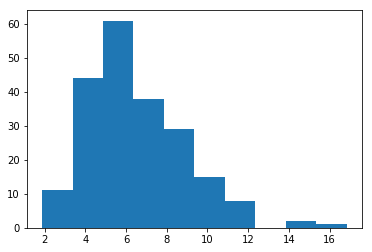

In [210]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(np.array(df_1.DT_ROOT_idx.apply(lambda x: np.array(x).mean())))
plt.show()

### Count of xxpass

In [175]:
df_1.DT_archs[0]

[u'nsubj ROOT mark nsubj ccomp acomp mark compound nsubj aux advcl amod punct compound dobj punct',
 u'advmod punct det amod nsubj prep compound pobj aux ROOT det compound punct compound dobj punct',
 u'nsubj prep pobj ROOT mark compound punct compound nsubj aux ccomp nsubj aux ccomp prep det pobj advmod cc conj dative amod dobj punct',
 u'advcl det dobj prep pobj prep pobj punct advmod nsubj advcl det compound attr punct nsubj ROOT prep pobj prep det pobj cc conj aux xcomp det compound attr det npadvmod punct',
 u'advmod prep prep poss pobj punct nsubj advmod ROOT det amod dobj prep pcomp prep pobj punct',
 u'prep det amod poss case pobj punct nsubj ROOT mark nsubj aux ccomp dobj nsubj relcl poss nsubj aux neg ccomp punct',
 u'nsubj ROOT det dobj dobj nsubj relcl prep det pobj prep det pobj prep poss compound punct pobj aux advcl amod dobj dobj det nsubj relcl punct',
 u'advmod punct nsubj ROOT acomp mark compound nsubj aux advcl det compound punct compound dobj punct',
 u'advmod punc

In [211]:
df_1['DT_pass_cnt'] = df_1['DT_archs'].apply(lambda x: [len([dep for dep in s.split(' ') if dep[-4:]=='pass']) for s in x])

### Count of 'mark'

In [212]:
#df_1['DT_pass_cnt'] = df_1['DT_archs'].apply(lambda x: [len([dep for dep in s.split(' ') if dep[-4:]=='pass']) for s in x])
df_1['DT_archs'][:3].apply(lambda x: [len([dep for dep in s.split(' ') if dep=='mark']) for s in x])



0    [2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]                  
1    [0, 2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0]               
2    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1]
Name: DT_archs, dtype: object

In [213]:
df_1['DT_mark_cnt'] = df_1['DT_archs'].apply(lambda x: [len([dep for dep in s.split(' ') if dep=='mark']) for s in x])


### Repetition of adjective POS

In [214]:
df_1.DT_pos[0]

[u'NOUN VERB ADP PRON VERB ADJ ADP NOUN NOUN PART VERB ADV PUNCT NOUN NOUN PUNCT',
 u'ADV PUNCT DET ADJ NOUN ADP NOUN NOUN VERB VERB DET ADJ PUNCT NOUN NOUN PUNCT',
 u'DET ADP PRON VERB DET NOUN PUNCT NOUN NOUN VERB VERB PRON PART VERB ADP DET NOUN ADV CCONJ VERB PRON ADJ NOUN PUNCT',
 u'VERB DET NOUN ADP NOUN ADP NOUN PUNCT ADV PROPN VERB DET NOUN NOUN PUNCT PRON VERB ADP NOUN ADP DET NOUN CCONJ VERB PART VERB DET NOUN NOUN DET NOUN PUNCT',
 u'ADV VERB ADP ADJ NOUN PUNCT PRON ADV VERB DET ADJ NOUN ADP VERB ADP NOUN PUNCT',
 u'ADP DET ADJ NOUN PART NOUN PUNCT PRON VERB ADP PRON VERB VERB NOUN PRON VERB ADJ NOUN VERB ADV VERB PUNCT',
 u'PRON VERB DET NOUN ADJ PRON VERB ADP DET NOUN ADP DET NOUN ADP ADJ ADJ PUNCT NOUN PART VERB ADJ NOUN NOUN DET NOUN VERB PUNCT',
 u'ADV PUNCT PRON VERB ADJ ADP NOUN NOUN PART VERB DET ADJ PUNCT NOUN NOUN PUNCT',
 u'ADV PUNCT ADJ NOUN ADV VERB ADV VERB PRON PART VERB ADJ PUNCT NOUN NOUN PUNCT',
 u'PRON VERB ADJ ADP ADJ NOUN CCONJ NOUN PUNCT',
 u'ADP ADJ NO

In [242]:
df_1['POS_adjv_body'] = df_1['essay_content'].apply(lambda x: [token.text.lower() for token in spc_nlp(x.decode('utf-8')) if (token.dep_=='amod')|(token.dep_=='advmod')])


In [244]:
df_1['POS_adjv_body'][:50].apply(lambda x: Counter(x).most_common(len(Counter(x).keys())/9)) # Get top 1/9 most common terms

0     [(good, 2)]                                
1     [(most, 4), (important, 3)]                
2     [(great, 3), (hard, 2)]                    
3     [(all, 2)]                                 
4     [(many, 4), (very, 3)]                     
5     []                                         
6     [(so, 3)]                                  
7     [(so, 3), (much, 2)]                       
8     [(so, 4), (when, 2)]                       
9     [(very, 4)]                                
10    [(so, 3), (more, 3)]                       
11    [(valuable, 2)]                            
12    [(how, 4), (more, 4)]                      
13    [(more, 2), (strong, 2)]                   
14    [(more, 5)]                                
15    [(more, 5), (only, 2), (most, 2)]          
16    [(also, 4), (own, 3)]                      
17    [(good, 2)]                                
18    [(large, 2), (more, 2)]                    
19    [(just, 2), (strongly, 1)]                 


### Count of PUNCT+FANBOYS

## Boundary

In [68]:
# archs
#df_2['DT_archs'] = df_2['essay_content'].apply(lambda x: [' '.join([token.dep_ for token in spc_nlp(s.text)]) for s in spc_nlp(x.decode('utf-8')).sents])
df_1['DT_archs'] = df_1['essay_content'].apply(lambda x: [' '.join([token.dep_ for token in spc_nlp(s.text)]) for s in spc_nlp(x.decode('utf-8')).sents])

In [ ]:
# pos
#df_2['DT_pos'] = df_2['essay_content'].apply(lambda x: [' '.join([token.pos_ for token in spc_nlp(s.text)]) for s in spc_nlp(x.decode('utf-8')).sents])
df_1['DT_pos'] = df_1['essay_content'].apply(lambda x: [' '.join([token.pos_ for token in spc_nlp(s.text)]) for s in spc_nlp(x.decode('utf-8')).sents])


In [72]:
# pos+archs
#df_2['DT_pos_archs'] = df_2['essay_content'].apply(lambda x: [' '.join([token.pos_+' '+token.dep_ for token in spc_nlp(s.text)]) for s in spc_nlp(x.decode('utf-8')).sents])


In [71]:
df_1.essay_content[0]

"\xef\xbb\xbfI agree that it is important for college students to have apart-time job. Nowadays, a large number of college students are having a part-time job. Some of them hold that part-time jobs can help them to adapt to the society well and give them many experiences. Take a friend of mine for example, when Lily was a college student, she went to supermarket as a promoter or went to be a family teacher every weekend. Then owing to her experiences, she quickly got a good job after graduating from university. in the other students' opinions, they think that they can buy goods they want their parents cannot afford. I know a student that he goes to a restaurant as a waiter at his part-time to earn enough money what a computer needs. Thus, it is important for college students to have a part-time job. However, our parents always don't agree us to get part-time jobs. They are afraid that our study and safety. In my opinion, having a good part-time job is good for students. We should pay a

In [ ]:
for i in xrange(df_2.shape[0]):
    if len(set(df_2.iloc[i,6]))!= len(df_2.iloc[i,6]):
        print len(set(df_2.iloc[i,6]))
        print len(df_2.iloc[i,6])

In [ ]:
pwk.ngram('A hearing is scheduled on the issue today', 4, ' ')

### Create dependency tree archs ngram

In [ ]:
df_1['DT_pos_join'] = df_1['DT_pos'].apply(lambda x: ' '.join(x))

### When using POS ngram, as n increases, the accuracy increases

In [ ]:
X = df_1['DT_pos_join']
#X = df_2['essay_content']
y = df_1['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)

In [ ]:
X = df_1['essay_content']
#X = df_2['essay_content']
y = df_1['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)

In [ ]:
pipeline_mnb = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2))),
    ('clf', MultinomialNB())
])
scores = cross_val_score(pipeline_mnb, X_train, y_train, cv=5)
print scores

In [ ]:
X_train_dtm.shape

In [ ]:
X = df_2['DT_pos_join']
#X = df_2['essay_content']
y = df_2['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
vectorizer = TfidfVectorizer(ngram_range=(3,3))
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)
#clf = LinearSVC()
clf = LogisticRegression()
clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)
print accuracy_score(y_test, y_pred)

In [ ]:
n = 4
df_2['DT_archs_ngram'] = df_2['DT_archs'].apply(lambda x: sum([pwk.ngram(s, n, ' ') for s in x],[]))

In [ ]:
df_2.head(1)

### Get the most common arch patterns

In [ ]:
Counter(df_2.iloc[3,8]).most_common(5)

### Create POS ngram

In [ ]:
n = 4
df_1['DT_pos_ngram'] = df_1['DT_pos'].apply(lambda x: sum([pwk.ngram(s, n, ' ') for s in x],[]))

In [ ]:
df_2.iloc[0,6]

In [ ]:
Counter(df_1.iloc[0,14]).most_common(7)

In [15]:
from nltk import ngrams
sentence = 'this is a foo bar sentences and i want to ngramize it'
n = 3
sixgrams = ngrams(sentence.split(), n)
for grams in sixgrams:
  print grams

('this', 'is', 'a')
('is', 'a', 'foo')
('a', 'foo', 'bar')
('foo', 'bar', 'sentences')
('bar', 'sentences', 'and')
('sentences', 'and', 'i')
('and', 'i', 'want')
('i', 'want', 'to')
('want', 'to', 'ngramize')
('to', 'ngramize', 'it')


In [24]:
df_1['DT_pos'][:1].values[0][0]

u'NOUN VERB ADP PRON VERB ADJ ADP NOUN NOUN PART VERB ADV PUNCT NOUN NOUN PUNCT'

In [84]:
#df_1['DT_pos'][:1].apply(lambda x: pwk.loop_body(x, 3))
n = 3
df_1['DT_insent_pos_ngram'] = df_1['DT_pos'].apply(lambda x: pwk.loop_body(x, n))

In [86]:
#df_1['DT_insent_pos_ngram']

**Stanford CoreNLP**

In [ ]:
from pycorenlp import StanfordCoreNLP
nlp = StanfordCoreNLP('http://localhost:9000')

In [ ]:
text = "It is important for college students to have apart-time job."

In [ ]:
output = nlp.annotate(text, properties={
        'annotators': 'tokenize,ssplit,pos,depparse,parse',\
        'outputFormat': 'json'
    })

In [ ]:
print output['sentences'][0]['parse']

## Simple Modeling

In [20]:
X = df_1['essay_content']
y = df_1['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [21]:
sum(y_train==1)*1./len(y_train)

0.5

In [44]:
'''
from nltk.stem.snowball import PorterStemmer

stemmer = PorterStemmer()
analyzer = TfidfVectorizer(ngram_range=(2,2)).build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))
'''

'\nfrom nltk.stem.snowball import PorterStemmer\n\nstemmer = PorterStemmer()\nanalyzer = TfidfVectorizer(ngram_range=(2,2)).build_analyzer()\n\ndef stemmed_words(doc):\n    return (stemmer.stem(w) for w in analyzer(doc))\n'

In [44]:
#vectorizer = CountVectorizer(lowercase=True, analyzer=stemmed_words)
vectorizer = CountVectorizer(lowercase=True, max_features=10)
#vectorizer = TfidfVectorizer(lowercase=True, use_idf=False, stop_words='english', ngram_range=(1,3))
#vectorizer = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(2,2))
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [45]:
X_train_dtm.shape

(10, 10)

In [46]:
terms = np.array(vectorizer.get_feature_names())#[-5:]

In [47]:
clf = LogisticRegression()
#clf.fit(X_train_dtm[120:140], y_train[120:140])
clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)

In [48]:
accuracy_score(y_test, y_pred)

0.80000000000000004

In [ ]:
from sklearn.svm import LinearSVC
clf = SGDClassifier()
clf.fit(X_train_dtm, y_train) 
y_pred = clf.predict(X_test_dtm)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
for i in xrange(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
    vectorizer = TfidfVectorizer(lowercase=True)
    X_train_dtm = vectorizer.fit_transform(X_train)
    X_test_dtm = vectorizer.transform(X_test)
    clf = LogisticRegression()
    clf.fit(X_train_dtm, y_train)
    y_pred = clf.predict(X_test_dtm)
    print accuracy_score(y_test, y_pred)

In [ ]:
#vectorizer = CountVectorizer(lowercase=True, analyzer=stemmed_words)
vectorizer = CountVectorizer(lowercase=True)
#vectorizer = TfidfVectorizer(lowercase=True, use_idf=False, stop_words='english', ngram_range=(2,2))
#vectorizer = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(2,2))
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [ ]:
clf = MultinomialNB()
#clf.fit(X_train_dtm[:100], y_train.iloc[:100])
clf.fit(X_train_dtm, y_train)
y_pred2 = clf.predict(X_test_dtm)

In [ ]:
accuracy_score(y_test, y_pred2)

In [ ]:
y_pred2

In [ ]:
y_test

In [ ]:
a = [1,2,3,4,5]

In [ ]:
a[1:]

In [ ]:
for i in range(120,140):
    clf = MultinomialNB()
    clf.fit(X_train_dtm[i:140], y_train[i:140])
    y_p = clf.predict(X_test_dtm)
    print '{}:'.format(i), accuracy_score(y_test, y_p) 
    print y_train.iloc[i]

### It turns out that if we control the topic, the vocabulary plays a significant role in classifying Chinese over native speakers, especially for Logistic Regression. Naive Bayes in this case doesn't perform well.

In [ ]:
idx = clf.coef_[0].argsort()[::-1][:10]

In [ ]:
terms[idx]

## Explore high tfidf score terms for each class

In [ ]:
vectorizer2 = TfidfVectorizer(lowercase=True, use_idf=False, stop_words='english')
#vectorizer = CountVectorizer(lowercase=True)
df_CHN = df_1[df_1['label']=='CHN']['essay_content']
test_dtm = vectorizer2.fit_transform(df_CHN)

In [ ]:
test_dtm.shape

In [ ]:
test_term = np.array(vectorizer2.get_feature_names())

In [ ]:
total = np.array(np.sum(test_dtm, axis=0))[0]

In [ ]:
test_term[total.argsort()[::-1][:10]]

In [ ]:
vectorizer3 = TfidfVectorizer(lowercase=True, use_idf=False, stop_words='english')
#vectorizer = CountVectorizer(lowercase=True)
df_ENS = df_1[df_1['label']=='ENS']['essay_content']
test_dtm_en = vectorizer3.fit_transform(df_ENS)

In [ ]:
test_dtm_en.shape

In [ ]:
test_term_en = np.array(vectorizer3.get_feature_names())
total_en = np.array(np.sum(test_dtm_en, axis=0))[0]

In [ ]:
test_term_en[total_en.argsort()[::-1][:10]]